# Vivqu Demo: data quality check for post monitoring

## 1. Background and Goal

Feature quality is of great important to machine learing model performance, in order to insure the intactness of data that come from multiple upstream data sources, I deviced a data quality checking library for post monitoring, which is named **vivqu**. 

Based on PyDeequ, it gives data scientists deep insight into the data quality, and enable them to check whichever metrics they are insterested in. It also simplifies the intricate process when using PyDeequ directly and make users able to do the checking job within a few lines of code.

Vivqu consists of several parts:
1. QualityChecker: provides several interfaces to measure the quality of current dataframe.
2. DataLoader: provides different ways to load data from multiple sources.
3. Visualizer: provides visualization for analysis or profile results.

I will show you how to use vivqu in a pyspark-notebook container, and run an example to demonstrate the convenience of using vivqu.

## 2. Environment configuration


I run this notebook in a pyspark-notebook container with the following command:

```
docker run -it -p 8888:8888 -v /Users/yangding/Documents/code/risk-data-quality-check/vivqu:/home/jovyan/vivqu jupyter/pyspark-notebook:a0a544e6dc6e
```

I didn't choose the latest version of pyspark-notebook image because the latest pydeequ (version = 1.0.1) only support pyspark version = 3.0, 2.6, 2.4.

## 3. Metrics

### 3.1 Analysis Metrics


| Metric | Description | Example |
| ----   | -----       | ----    |
|ApproxCountDistinct | Approximate number of distinct value, computed with HyperLogLogPlusPlus sketches. | `ApproxCountDistinct("review_id")` |
| ApproxQuantile | Approximate quantile of a distribution. | `ApproxQuantile("star_rating", quantile = 0.5)`
| ApproxQuantiles | Approximate quantiles of a distribution. | `ApproxQuantiles("star_rating", quantiles = [0.1, 0.5, 0.9])`
| Completeness | Fraction of non-null values in a column. | `Completeness("review_id")`
| Compliance | Compliance | `Compliance("volume", "volume >= 28")`
| CountDistinct| Number of distinct values.| `CountDistinct("review_id")`
| Correlation | Pearson correlation coefficient, measures the linear correlation between two columns. The result is in the range [-1, 1], where 1 means positive linear correlation, -1 means negative linear correlation, and 0 means no correlation.| `Correlation("total_votes", "star_rating")`
| DataType | Distribution of data types such as Boolean, Fractional, Integral, and String. The resulting histogram allows filtering by relative or absolute fractions. | `DataType("year")`
| Distinctness | Fraction of distinct values of a column over the number of all values of a column. Distinct values occur at least once. Example: [a, a, b] contains two distinct values a and b, so distinctness is 2/3. | `Distinctness("review_id")`
| Entropy | Entropy is a measure of the level of information contained in an event (value in a column) when considering all possible events (values in a column). It is measured in nats (natural units of information). Entropy is estimated using observed value counts as the negative sum of (value_count/total_count) * log(value_count/total_count). Example: [a, b, b, c, c] has three distinct values with counts [1, 2, 2]. Entropy is then (-1/5\*log(1/5)-2/5\*log(2/5)-2/5\*log(2/5)) = 1.055. | `Entropy("star_rating")`
| Maximum | Maximum value. | `Maximum("star_rating")`
| Mean | Mean value; null values are excluded. | `Mean("star_rating")`
| Minimum | Minimum value. | `Minimum("star_rating")`
| MutualInformation | Mutual information describes how much information about one column (one random variable) can be inferred from another column (another random variable). If the two columns are independent, mutual information is zero. If one column is a function of the other column, mutual information is the entropy of the column. Mutual information is symmetric and nonnegative. | `MutualInformation(Seq("total_votes", "star_rating"))`
| Size | Number of rows in a DataFrame. | `Size()`
| Sum | Sum of all values of a column.| `Sum("total_votes")`
| UniqueValueRatio | Fraction of unique values over the number of all distinct values of a column. Unique values occur exactly once; distinct values occur at least once. Example: [a, a, b] contains one unique value b, and two distinct values a and b, so the unique value ratio is 1/2. | `UniqueValueRatio("star_rating")`
| Uniqueness | Fraction of unique values over the number of all values of a column. Unique values occur exactly once. Example: [a, a, b] contains one unique value b, so uniqueness is 1/3. | `Uniqueness("star_rating")`





## 4. Example

### 4.1 Load needed modules

Before using vivqu, you need to install pydeequ, default verison is 1.0.1.

In [2]:
# install pydeequ, latest version should be 1.0.1
# !pip install pydeequ

In [3]:
import pyspark
from pyspark.sql import SparkSession
import pydeequ
from pydeequ.analyzers import *

Please set env variable SPARK_VERSION


In [4]:
import sys
sys.path.append("..")
from vivqu import *

In [5]:
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [6]:
# create spark session locally
# it may cost a lot time on first run
spark_session = (
    SparkSession.builder
    .config("spark.jars.packages", pydeequ.deequ_maven_coord)
    .config("spark.jars.excludes", pydeequ.f2j_maven_coord)
    .getOrCreate()
    )

Ivy Default Cache set to: /Users/yangding/.ivy2/cache
The jars for the packages stored in: /Users/yangding/.ivy2/jars
:: loading settings :: url = jar:file:/Users/yangding/opt/anaconda3/envs/spark/lib/python3.9/site-packages/pyspark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
com.amazon.deequ#deequ added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-3953defd-10c9-4ec2-aef9-4e863fbafbf0;1.0
	confs: [default]
	found com.amazon.deequ#deequ;1.2.2-spark-3.0 in central
	found org.scalanlp#breeze_2.12;0.13.2 in central
	found org.scalanlp#breeze-macros_2.12;0.13.2 in central
	found org.scala-lang#scala-reflect;2.12.1 in central
	found com.github.fommil.netlib#core;1.1.2 in central
	found net.sf.opencsv#opencsv;2.3 in central
	found com.github.rwl#jtransforms;2.4.0 in central
	found junit#junit;4.8.2 in central
	found org.apache.commons#commons-math3;3.2 in central
	found org.spire-math#spire_2.12;0.13.0 in central
	found org.spire-math#

### 4.2 DataLoader

Provide three mothods to various data sources:
+ load_list()      # load from existing python list
+ load_csv()       # load from csv file
+ load_bigquery()  # haven't been implemented

In [7]:
# load data from sample csv
loader = DataLoader(spark_session)

In [8]:
df = loader.load_csv("risk_unified_transaction_100.csv")
df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Booking_account_ID: string (nullable = true)
 |-- Booking_Legal_Entity_ID: string (nullable = true)
 |-- Booking_Legal_Entity_Name_Local: string (nullable = true)
 |-- Booking_Legal_Entity_Name_English: string (nullable = true)
 |-- Booking_Legal_Entity_Owningentity: string (nullable = true)
 |-- Booking_account_Owner_Org_Level: string (nullable = true)
 |-- Transaction_Domain: string (nullable = true)
 |-- Transaction_Type_Raw: string (nullable = true)
 |-- Transaction_Direction: string (nullable = true)
 |-- Originator_internal_account_ID: string (nullable = true)
 |-- Originator_Legal_Entitiy_ID: string (nullable = true)
 |-- Beneficiary_internal_account_ID: string (nullable = true)
 |-- Beneficiary_Legal_Entity_ID: string (nullable = true)
 |-- Transaction_Status_Raw: string (nullable = true)
 |-- Datetime_created: timestamp (nullable = true)
 |-- Transaction_method: string (nullable = true)
 |-- Transaction_moneyhouse: string (nullable =

### 4.3 QualityChecker

In [9]:
# create quality checker
checker = QualityChecker(spark_session)

#### 4.3.1 QualityChecker.analyze()

In [10]:
# use three customized metrics to analyze
analyze_result = checker.analyze(
                    df, [ 
                    Default("Transaction_reason"),
                    Default("Original_amount_currency"),
                    Default("Beneficiary_bank_name"),
                    Default("Original_amount_USD"),
                    Default("Original_amount_orig_ccy"),
                    Default("Original_Inverse_USD"),
                    ]
                )
                
analyze_result

22/08/02 09:50:58 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,entity,instance,name,value
0,Column,Original_amount_currency,Completeness,1.000000
1,Column,Beneficiary_bank_name,CountDistinct,61.000000
2,Column,Transaction_reason,Histogram.bins,18.000000
3,Column,Transaction_reason,Histogram.abs.Seller Never Shipped,4.000000
4,Column,Transaction_reason,Histogram.ratio.Seller Never Shipped,0.040000
...,...,...,...,...
192,Column,Original_amount_USD,Minimum,0.155841
193,Column,Original_amount_USD,ApproxQuantiles-0.25,1.000000
194,Column,Original_amount_USD,ApproxQuantiles-0.5,1.912845
195,Column,Original_amount_USD,ApproxQuantiles-0.75,6.070000


### 4.4 Visualizer

In [14]:
dic = convert_df_to_dict(analyze_result)
print(json.dumps(dic, indent=4))

{
    "Original_amount_currency": {
        "Completeness": 1.0,
        "CountDistinct": 5.0,
        "Category": [
            "HKD",
            "AUD",
            "GBP",
            "USD",
            "EUR"
        ],
        "Data": [
            1.0,
            1.0,
            11.0,
            82.0,
            5.0
        ]
    },
    "Beneficiary_bank_name": {
        "CountDistinct": 61.0,
        "Category": [
            "BANQUE FEDERATIVE DU CREDIT MUTUEL (BFCM)",
            "BANK OF MONTREAL",
            "CREDIT ANDORRA",
            "VISA AUSTRIA",
            "HSBC BANK PLC",
            "HALIFAX PLC",
            "DZ BANK AG DEUTSCHE ZENTRAL-GE",
            "TNG (ASIA) LIMITED",
            "BANQUE SAUDI FRANSI",
            "SYNCHRONY BANK",
            "N26 GMBH",
            "STANDARD CHARTERED BANK (HONG KONG), LTD.",
            "NullValue",
            "COOPERATIEVE RABOBANK U.A.",
            "UBS SWITZERLAND AG",
            "BRANCH BANKING AND TRUST COMPA

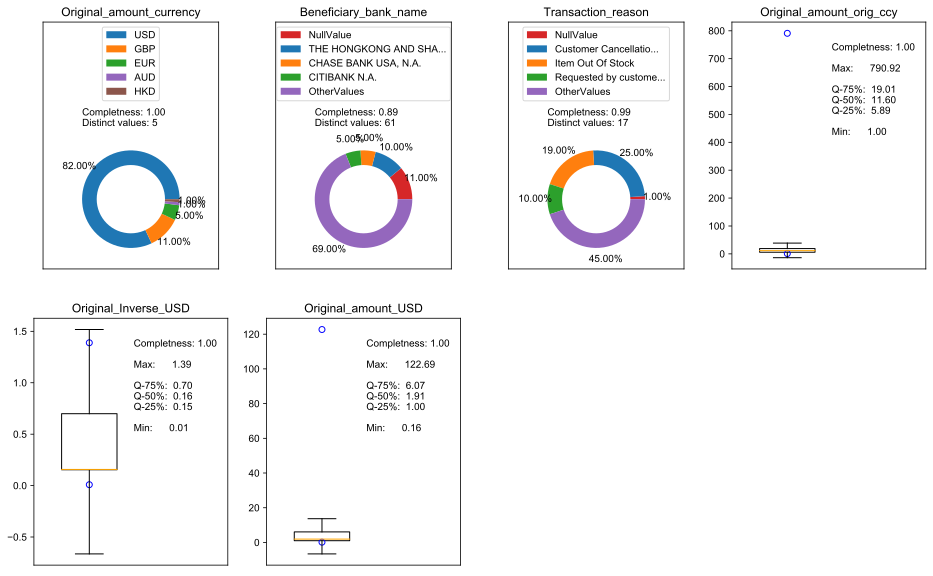

In [12]:
vis(analyze_result)

## 3. Q&A

1. How to improve the interface of QualityChecker, DataLoader and so on?

2. Do I need to provide profile interface, constraint suggestion and constraint verification interface?

3. Do I need to implement the visualization method? If so, does the above visualization example from kaggle appropriate? 

## 4. TODO

calculate the difference of two or more dataframes

use heatmap to show difference of metrics in a period of continuous time 

cut large datarframe to slices (weekly, daily or by some specific value)

set threshold of analysis value to give alerts